In [5]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

In [6]:
# Load and merge datasets
customers = pd.read_csv('Customers.csv')

In [11]:
customers.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [7]:
transactions = pd.read_csv('Transactions.csv')

In [12]:
transactions.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [8]:
data = pd.merge(customers, transactions, on='CustomerID')

In [19]:
data['SignupDate'] = pd.to_datetime(data['SignupDate'])

# Feature engineering: Calculate total spending, frequency, and recency
data['TotalSpending'] = data['Quantity'] * data['Price']

# Calculate recency using the maximum 'SignupDate' as a datetime object
recency = data.groupby('CustomerID')['SignupDate'].max()
recency = (data['SignupDate'].max() - recency).dt.days

frequency = data.groupby('CustomerID')['SignupDate'].nunique()  # Assuming 'signupDate' is correct column
monetary = data.groupby('CustomerID')['TotalSpending'].sum()

In [20]:

# Create a new DataFrame for clustering
clustering_data = pd.DataFrame({
    'Recency': recency,
    'Frequency': frequency,
    'Monetary': monetary
}).dropna()

In [21]:
# Normalize the data
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)


In [22]:


# Determine the optimal number of clusters using the Elbow Method
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_data_scaled)
    inertia.append(kmeans.inertia_)

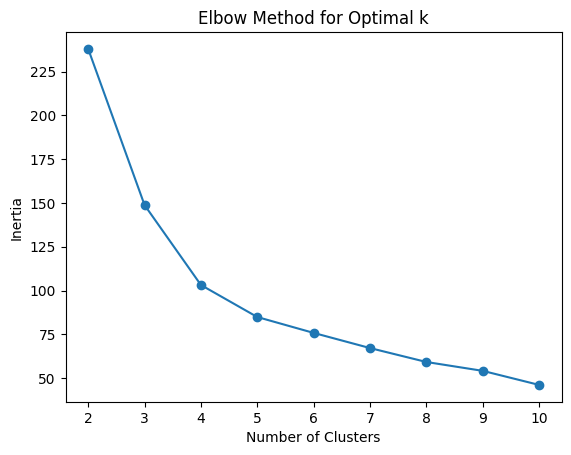

In [23]:
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


In [24]:

# Apply K-Means with the chosen number of clusters (e.g., 4)
kmeans = KMeans(n_clusters=4, random_state=42)
clustering_data['Cluster'] = kmeans.fit_predict(clustering_data_scaled)

In [25]:
# Evaluate clustering performance
sil_score = silhouette_score(clustering_data_scaled, clustering_data['Cluster'])
db_index = davies_bouldin_score(clustering_data_scaled, clustering_data['Cluster'])
print(f'Silhouette Score: {sil_score}')
print(f'Davies-Bouldin Index: {db_index}')

Silhouette Score: 0.4153036301167133
Davies-Bouldin Index: 0.7946373546988293


In [26]:

# Visualize clusters using PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(clustering_data_scaled)
clustering_data['PCA1'] = pca_components[:, 0]
clustering_data['PCA2'] = pca_components[:, 1]

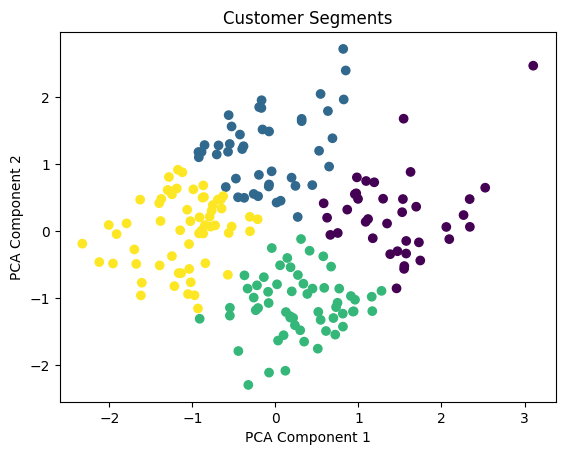

In [27]:

plt.scatter(clustering_data['PCA1'], clustering_data['PCA2'], c=clustering_data['Cluster'], cmap='viridis')
plt.title('Customer Segments')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [29]:
# Count the number of points in each cluster
cluster_counts = clustering_data['Cluster'].value_counts()

# Print the cluster counts
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} points")

Cluster 3: 60 points
Cluster 2: 58 points
Cluster 1: 44 points
Cluster 0: 37 points
